#### Part 1: Read cell body position from .apo files, downsample and save them as txt file for applying inverse transformation

In [1]:
import Neuron_analysis as na
from Neuron_analysis import *

import os
import pandas as pd
import re

import tkinter as tk
import tkinter.filedialog as fdialog
from tkinter import simpledialog

import skimage

import cc3d

import numpy as np
import matplotlib.pyplot as plt

from read_roi import read_roi_file

In [2]:
indir = fdialog.askdirectory(title='Select the directories with all the cell bodies.apo')
outdir = fdialog.askdirectory(title='Select the output directory to store your file')

files = os.listdir(indir)

In [69]:
def prepare_cellbody(indir,anno_file,outdir):
    anno=open(os.path.join(indir,anno_file),'r')
    anno_data=anno.readlines()
 
    headings=anno_data[0].rstrip('\n').split(',')
    annotations=[lines.rstrip('\n').split(',') for lines in anno_data[1:]]
    annotation_df=pd.DataFrame(annotations, columns=headings)
    
    cell_body= annotation_df[annotation_df.color_g=='255']
    #pickout only green points!
    
    # find the coordinates and downsample it! these values are based on xy= 0.6 z= 5, and downsampling to 25 xyz
    ds_x= pd.to_numeric(cell_body['x'])//41
    ds_y= pd.to_numeric(cell_body['y'])//41
    ds_z= pd.to_numeric(cell_body['z'])//5

    x=ds_x.astype(int).astype(str)
    y=ds_y.astype(int).astype(str)
    z=ds_z.astype(int).astype(str)
    
    m=re.search('\D{2}[0-9]{3}', anno_file)
    mouse_name=m[0]

    out_name=os.path.join(outdir,mouse_name+'cellbody.txt')

    f=open(out_name,'w+')
    f.write('point'+'\n')
    f.write('1'+'\n') # by default there is only 1 cell body, hence only 1 point here
    f.write(x.values[0]+ ' ' + y.values[0]+ ' '+ z.values[0])
    f.close()
    return
    

In [70]:
for items in files:
    prepare_cellbody(indir, items, outdir)

### Part2  : (after transformation by transformix) extract the transformed points, refill y section (because we cropped the template for registration). 
Then write as a single file containing brain ID and cell body location

___Work in progress___

In [3]:
brain_id= ['AL175', 'AL223','AL230', 'AL236','AL242', 'AL244', 'AL261']
#missing 'AL225' 
cb_file=f'D:\{brain_id[1]}\points\cellbody\outputpoints.txt'

In [4]:
all_points=[]

for items in brain_id:
    this_file=cb_file=f'D:\{items}\points\cellbody\outputpoints.txt'
    
    template_file = [x for x in os.listdir(f'D:\{items}\\') if 'template' in x]
    to_add=na.find_crop(template_file[0])
  
    with open(cb_file,'r') as output:
        outputpoint= output.readlines()

    for lines in outputpoint:
        m=re.search("(?:OutputIndexFixed = \[ )([0-9]+ [0-9]+ [0-9]+)", lines).groups(0)
        this_line= str(m[0]).split(' ')
        mypoints= [int(stuff) for stuff in this_line]
        mypoints[1]= mypoints[1]+to_add
        mypoints.insert(0, items)
        all_points.append(mypoints)
        
# the coordiates are arranged in x,y and z

In [5]:
all_points

[['AL175', 92, 283, 52],
 ['AL223', 99, 279, 47],
 ['AL230', 88, 275, 56],
 ['AL236', 104, 279, 40],
 ['AL242', 136, 263, 33],
 ['AL244', 86, 302, 47],
 ['AL261', 123, 261, 42]]

In [8]:
cell_bodies= pd.DataFrame(all_points, columns= ['name', 'x', 'y', 'z'])

In [10]:
cell_bodies

,name,x,y,z
0,AL175,92,283,52
1,AL223,99,279,47
2,AL230,88,275,56
3,AL236,104,279,40
4,AL242,136,263,33
5,AL244,86,302,47
6,AL261,123,261,42


## (old)Part for viral cellbody ROIs (after segmentation and curation in LabKit)

ImageJ plugin https://imagej.net/plugins/labkit/

In [95]:
outdir = fdialog.askdirectory(title='Select the output directory to store your file')

In [73]:
image_name = fdialog.askopenfile(title='Select the binary image').name
mouse_name=na.find_mousename(image_name)


In [107]:
def prepare_cellbody_virus(tiff_file, threshold=5):
    '''From curated segmentation tiff file, find connected components(3d) with their area and centeroid.
    
    threshold: connected components with numbers of pixels below this number will get removed
    
    saves .txt file compatible for transformix (and downsampled to 25um space) and a .csv file listing the area and the centroid x,y,z coordinate (not downsampled) for each component
    '''
    
    im= skimage.io.imread(tiff_file) 
        
    labels=skimage.measure.label(im)
    info= skimage.measure.regionprops(labels)
    
    real_cells= [items for items in info if items.area>threshold]
    # remove connected components that are less than 5 pixels for example
    areas=[item.area for item in real_cells]
    
    center= [item.centroid for item in real_cells]
    center=np.asarray(center)
    
    headings=['x', 'y', 'z']
    #points=[lines.rstrip('\n').split(',') for lines in anno_data[1:]]
    centroid_df=pd.DataFrame(center, columns=headings)
    centroid_df['area']= areas
    return centroid_df

def refill_roi(centroid_df):
    
    ''' Find x, y, z section to refill from .roi file (account for x and y) and substack file name (account for z)
    refill the input dataframe's 'x', 'y', 'z' to match the original image size. Input data frame is usually an output from prepare_cellbody_virus
    '''
    roi_name = fdialog.askopenfile(title='Select the roi').name
    roi = read_roi_file(roi_name)
    name=list(roi.keys())[0]
    x_add=roi[name]['left']-1
    y_add=roi[name]['top']-1
    substack_name = fdialog.askopenfile(title='Select the substack used for cellbody segmentation').name
    m= re.search("(?<=_)[0-9]{1,3}.[0-9]{1,3}",substack_name)[0]
    to_add= m.split('-')
    lead= int(to_add[0])-1
    centroid_df['x']+= x_add
    centroid_df['y']+= y_add
    centroid_df['z']+= lead
    
    return centroid_df

def make_transformix_txt(centroid_df,mouse_name): #work in progress

    # find the coordinates and downsample it! these values are based on xy= 0.6 z= 5, and downsampling to 25 xyz
    ds_x= pd.to_numeric(centroid_df['x'])//5
    ds_y= pd.to_numeric(centroid_df['y'])//5
    ds_z= pd.to_numeric(centroid_df['z'])//5

    x=ds_x.astype(int).astype(str)
    y=ds_y.astype(int).astype(str)
    z=ds_z.astype(int).astype(str)
    
    q = [' '.join(x) for x in zip(x,y,z)]
    num_row=len(q)

    out_name=os.path.join(outdir,mouse_name+'cellbody.txt')

    f=open(out_name,'w+')
    f.write('point'+'\n')
    f.write(str(num_row)+'\n')
    for lines in q:
        f.write(lines+'\n')
    f.close()
    
    return

In [91]:
cell_body=prepare_cellbody_virus(image_name, threshold=5)
cell_body

,x,y,z,area
0,3.703704,180.407407,153.518519,27
1,7.030075,119.902256,150.300752,133
2,17.102345,137.281450,133.098081,469
3,14.987342,120.278481,143.550633,158
4,13.380952,121.492063,201.539683,63
...,...,...,...,...
176,128.333333,59.666667,43.875000,24
177,128.869565,80.630435,36.760870,46
178,132.437500,65.687500,47.875000,16
179,134.555556,74.888889,21.222222,9


In [92]:
cell_body_refill= refill_roi(cell_body)
cell_body_refill

In [98]:
out_name=os.path.join(outdir,mouse_name+'cellbody.csv')
cell_body_refill.to_csv(out_name)

In [108]:
make_transformix_txt(cell_body_refill,mouse_name)

## Part for rough injection site segmented with Labkit from registered downsampled images

In [1]:
import Neuron_analysis as na
from Neuron_analysis import *

import os
import pandas as pd
import re

import tkinter as tk
import tkinter.filedialog as fdialog
from tkinter import simpledialog

import skimage

import cc3d

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt

from tqdm import tqdm

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


In [6]:
indir = fdialog.askdirectory(title='Select the directories with all the injection site tif stacks')
outdir = fdialog.askdirectory(title='Select the output directory to store the results')

files = os.listdir(indir)

In [7]:
def prepare_injsite(tiff_file, lead, outdir): 
    #WORKINPROGRESS
    '''From injection site tiff file, find the cropped regions and add it back(so the dimension matches the full atlas)
    save as tiff file
    '''
    
    
    im= skimage.io.imread(tiff_file) 
    
    atlas_shape=(320, 528, 456)
    coords= np.argwhere(im>0)
    
    refilled_coords=np.zeros(atlas_shape)
    for lines in coords:
        refilled_coords[lines[0],lines[1]+lead, lines[2]]=255
        
    horizontal= np.int16(refilled_coords)

    out_name=os.path.basename(tiff_file)[:-4]
    skimage.io.imsave(f'{outdir}//{out_name}_full.tiff',horizontal)

    return 

In [8]:
for i in tqdm(files):

    tiff_file=os.path.join(indir,i) 
    mouse_name=na.find_mousename(i)

    template_dir= f'M:\\analysis\\Yanqi_Liu\\Viral_staskc_L56\\{mouse_name}'
    template_name= [i for i in os.listdir(template_dir) if 'template_' in i]
    lead= na.find_crop(template_name[0])
    
    prepare_injsite(tiff_file, lead, outdir)    


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL207_647_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
  8%|██████▍                                                                            | 1/13 [00:01<00:21,  1.79s/it]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL209_647_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
 15%|████████████▊                                                                      | 2/13 [00:03<00:19,  1.79s/it]C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/viral_injsite_results//AL210_647_full.tiff is a low contrast image
  warn('%s is a low contrast image' % fn

In [ ]:
# now use these injection site tiff with full dimension to find information
# number of voxels, centroid, centroid id, and voxel id
# organize in pandas dataframe and save as excel file

Coronal atlas has shape (528, 320, 456)
Converted to horizontal atlas with shape (456, 528, 320)


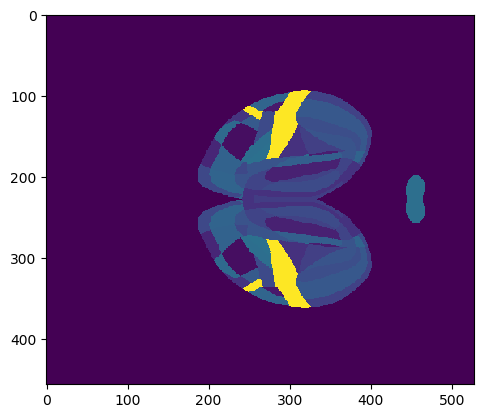

In [2]:
mcc = MouseConnectivityCache(resolution=25)

annot, annot_info = mcc.get_annotation_volume()

print('Coronal atlas has shape', annot.shape)

annot_h=np.moveaxis(annot, 2, 0) #reslice corontal atlas to horizontal atlas
print('Converted to horizontal atlas with shape', annot_h.shape)

plt.imshow(annot_h[:,:,36], interpolation='nearest', vmin=0, vmax=3000)
plt.show()
# although in this plot it looks like the image should rotate 90 degrees to the right but it actually matches the dimension of image

In [3]:
indir_injectionsite = fdialog.askdirectory(title='Select the directories with all the injection site tif FULL stacks')
# now indicate the folder contaning outputs from prepare_injsite. Now all tiff will have the same dimension as the full atlas
files = os.listdir(indir_injectionsite)
#full_file=os.path.join(indir_injectionsite, files[2])

In [4]:
d = {'Data_name':[], 'Total_voxels':[] , 'Centroid_location': [],'Centroid_id':[],'Voxel_id':[] }
results=pd.DataFrame(data=d)

In [6]:
for i in tqdm(files):
    full_file=os.path.join(indir_injectionsite, i)    
    im= skimage.io.imread(full_file)
    # read the files
    
    labels_out = cc3d.connected_components(im,connectivity=6)
    stats = cc3d.statistics(labels_out)
    # find relevant info using cc3d
    
    centroid_round = stats['centroids'][1].astype(int)
    centroid_id = int(annot_h[(centroid_round[2]), centroid_round[1], centroid_round[0]])
    
    coords= np.argwhere(im>0) # find an atlas id for each coordinate
    points_in_atlas=[]
    for j in coords:
        points_in_atlas.append(int(annot_h[j[2], j[1],j[0]]))
        #note this order of dimensions
    unique, counts = np.unique(points_in_atlas, return_counts=True)
    id_count=dict(zip(unique, counts))
    
    results= results.append ({'Data_name':f'{i[:9]}', 'Total_voxels':stats['voxel_counts'][1], 
                 'Centroid_location': centroid_round, 'Centroid_id':centroid_id, 'Voxel_id':[id_count] }, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:18<00:00,  6.01s/it]


In [7]:
results

,Data_name,Total_voxels,Centroid_location,Centroid_id,Voxel_id
0,AL207_647,6480.0,"[60, 276, 121]",1070.0,"[{9: 23, 1038: 1543, 1047: 14, 1070: 3873, 111..."
1,AL209_647,4218.0,"[69, 270, 109]",1070.0,"[{1038: 75, 1047: 11, 1070: 4132}]"
2,AL210_647,1855.0,"[52, 287, 122]",1070.0,"[{1047: 10, 1070: 1134, 1111: 159, 312782558: ..."
3,AL211_647,1584.0,"[66, 276, 106]",1070.0,"[{1047: 94, 1070: 1490}]"
4,AL213_647,2944.0,"[73, 272, 98]",1070.0,"[{1047: 44, 1070: 2900}]"
5,AL215_647,2543.0,"[67, 279, 102]",1070.0,"[{1038: 532, 1047: 1022, 1070: 989}]"
6,AL273_647,3158.0,"[63, 273, 118]",1070.0,"[{1038: 636, 1070: 2514, 182305705: 8}]"
7,AL274_561,2205.0,"[106, 284, 77]",862.0,"[{862: 1958, 1090: 247}]"
8,AL274_647,5471.0,"[80, 283, 102]",1038.0,"[{1038: 4515, 1062: 286, 1070: 587, 484682520:..."
9,AL278_647,1221.0,"[94, 282, 70]",1090.0,"[{1035: 68, 1047: 2, 1070: 52, 1090: 1099}]"


In [8]:
results.to_excel(r'D:\viral_injectionsite\results.xlsx')

### For visualization and plotting!

In [12]:
import numpy as np
import numpy.ma as ma

from skimage import measure
import SimpleITK as sitk

import plotly
import plotly.offline
import plotly.graph_objects as go

In [13]:
atlas= sitk.ReadImage('D:\\Allenbrainatlas\\ARA_25_micron_mhd_ccf2017\\annotation_25_horizontal.mhd')

In [14]:
volume= sitk.GetArrayFromImage(atlas) # read the atlas image
x=ma.masked_greater(volume,0) #take every structure of the brain(anything greater than 0)
brain=x.mask

In [15]:
verts, faces, normals, values = measure.marching_cubes_lewiner(brain, level=None, spacing=(1.0, 1.0, 1.0),step_size=10)

In [16]:
y=ma.masked_equal(volume,201)
l23=y.mask

#select ssp-bfd layer 23, id 201

In [17]:
verts2, faces2, normals2, values2 = measure.marching_cubes_lewiner(l23, level=None, spacing=(1.0, 1.0, 1.0),step_size=1)

In [20]:
x, y, z = verts.T
i,j,k = faces.T

color=[1,2,3,4,5,6,7,8]

x2, y2, z2 = verts2.T
i2,j2,k2 = faces2.T


fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.20,
                               i=i,
                               j=j,
                            k=k,)])

fig.add_trace(go.Mesh3d(x=x2, y=y2, z=z2, color='blue', opacity=0.20,
                               i=i2,
                               j=j2,
                            k=k2,))

fig.add_trace(go.Scatter3d(z=cell_bodies['x'], y=cell_bodies['y'],x=cell_bodies['z'],  mode='markers', hovertext=cell_bodies['name'] ,marker=dict(size=3, color=color)))
#shift x and z to match the space of the allen atlas!

fig['data'][0]['showlegend'] = True
fig['data'][0]['name'] = 'Brain'

fig['data'][1]['showlegend'] = True
fig['data'][1]['name'] = 'Ssp-bfd-L23'

fig['data'][2]['showlegend'] = True
fig['data'][2]['name'] = 'Cell bodies'
# Have to go in and specify since the legends are not automatically displayed in this case

fig.show()
fig.write_html('test_cellbodies.html')

ValueError: 
    Invalid element(s) received for the 'color' property of scatter3d.marker
        Invalid elements include: ['AL175', 'AL223', 'AL230', 'AL236', 'AL242', 'AL244', 'AL261']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter3d.marker.colorscale
      - A list or array of any of the above